### Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import recall_score
import torch
#from imblearn.over_sampling import SMOTE

In [10]:
# Check if Cuda is running
#torch.cuda.get_device_name(0)

In [22]:
data = pd.read_csv("creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [23]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
124011,77147.0,-1.437314,-0.672735,0.925002,-0.728117,-0.498919,-1.088232,0.098312,0.294362,-1.763211,...,-0.032172,-0.254662,0.569343,0.599137,-0.909906,0.070153,0.017838,0.001861,149.20,0
182926,125586.0,-1.188026,0.648003,0.195708,-2.300317,-1.876858,0.483442,-0.257970,-4.314653,1.394378,...,3.773234,-1.129681,-1.190132,0.066215,0.806729,0.669240,0.580496,0.090244,392.00,0
2807,2364.0,1.571567,-0.852696,-0.411170,-1.735533,-0.574247,-0.298426,-0.606201,-0.165091,-2.384797,...,-0.546954,-1.269700,0.009546,-0.896239,0.433003,-0.425964,0.000977,-0.003500,19.75,0
10848,18552.0,-0.265284,0.081207,1.595559,-1.671107,-0.359368,-0.158713,-0.188054,0.271057,2.710338,...,0.102560,0.673973,0.126516,-0.065758,-1.159539,-1.066871,0.283226,0.230268,11.85,0
250966,155148.0,-1.071928,0.594211,-0.352817,-0.819417,1.439513,0.755137,0.594540,0.448423,0.063034,...,-0.085680,0.088365,0.361190,-0.336159,-1.006584,0.176926,-0.098098,0.001136,14.75,0


In [24]:
data.ndim

2

### Data Analysis

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.174225e-15,3.429687e-16,-1.386421e-15,2.073779e-15,9.939598e-16,1.493625e-15,-5.931037e-16,1.318317e-16,-2.414318e-15,...,1.416845e-16,-3.515296e-16,2.727492e-16,4.482012e-15,5.203181e-16,1.689590e-15,-3.712632e-16,-1.159267e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

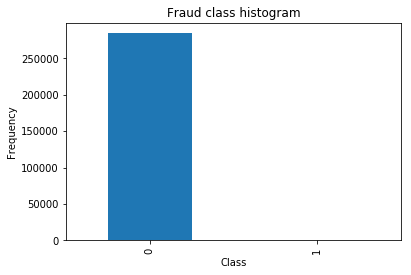

In [8]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [9]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

## 1. Run with Normalising data

In [234]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [235]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 29)
xtest shape
(85443, 29)


In [236]:
# Normalising the training data and test data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [237]:
# Fit classifier to a model
classifier = RandomForestClassifier()
classifier.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [238]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_normalized)

In [239]:
# Making a Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85291,     5],
       [   39,   108]])

In [240]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.96      0.73      0.83       147

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999485
Area under the curve : 0.867318


## 2. Run with Over Sampling data using SMOTE (Synthetic Minority Over-sampling Technique)

In [2]:
from imblearn.over_sampling import SMOTE

In [4]:
data = pd.read_csv("creditcard.csv")

NameError: name 'pd' is not defined

In [17]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [18]:
X = np.array(data.ix[:, data.columns != 'Class'])
y = np.array(data.ix[:, data.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 29)
Shape of y: (284807, 1)


In [19]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 29)
xtest shape
(85443, 29)


In [20]:
# Over Sampling data using SMOTE
smote = SMOTE(random_state=2)
X_train_resample, y_train_resample = smote.fit_sample(X_train, y_train.ravel())

In [21]:
classifier = RandomForestClassifier()
classifier.fit(X_train_resample, y_train_resample.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [23]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85283,    13],
       [   31,   116]])

In [24]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.90      0.79      0.84       147

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999485
Area under the curve : 0.894482


## 3. Run with GANs

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

In [31]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

OUTPUT_PATH = '/output/'
MODE = 'wgan-gp'
RESTORE_MODE = False # If this flag is True, it will continue to train from the saved model.

# Custom DataLoader
class FraudDataset(Dataset):
    
    # Initialize the data
    def __init__(self):
        data = pd.read_csv("creditcard.csv")
        data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
        data = data.drop(['Time','Amount'],axis=1)
        
        # Rearrange columns to the right order
        cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
        'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normAmount', 'Class']
        data = data[cols]
        
        fraud_data = data.loc[data['Class']==1]
        fraud_data = fraud_data.drop('Class', 1)
        self.len = fraud_data.shape[0]
        
        self.fraud_data = torch.FloatTensor(np.array(fraud_data))
        
        #self.X = np.array(data.loc[:, data.columns != 'Class'])
        #self.y = np.array(data.loc[:, data.columns == 'Class'])
        
        #self.X = torch.FloatTensor(self.X)
        #self.y = torch.FloatTensor(self.y)
        
    def __getitem__(self, index):
        return self.fraud_data[index]
    
    def __len__(self):
        return self.len

In [4]:
if RESTORE_MODE:
    generator = torch.load(OUTPUT_PATH + "generator.pt" )
    discriminator = torch.load(OUTPUT_PATH + "discriminator.pt")   

In [32]:
dataset = FraudDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1)

In [33]:
# Generator's paragrams
g_input_size = 29     # Random noise dimension
g_hidden_size = 50   # Generator complexity
g_output_size = 1   
g_learning_rate = 0.0002

#Discriminator's paragrams
d_input_size = 29   # Minibatch size
d_hidden_size = 50  # Discriminator complexity
d_output_size = 1   # Single dimension for 'real' vs. 'fake'
d_learning_rate = 0.0002

minibatch_size = d_input_size

num_epochs = 2000
print_interval = 10

In [34]:
# Generator
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # ELU (Exponential Linear Unit) function tends to converge cost to zero faster and produce more accurate results
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [35]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.map1(x)
        x = F.elu(x)
        x = self.map2(x)
        x = F.elu(x)
        x = self.map3(x)
        return F.sigmoid(x)

In [36]:
generator = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
discriminator = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

In [37]:
# Uncomment these 2 lines to run on GPU
#generator.cuda()
#discriminator.cuda()

In [38]:
def plot(disc):
    h=0.1
    x_min, x_max = data[:, 0].min() - .5, data[:, 0].max() + .5
    y_min, y_max = data[:, 1].min() - .5, data[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    x_test = np.c_[xx.ravel(), yy.ravel()]
    y_hat_test = disc.forward_with_sigmoid(Variable(torch.from_numpy(x_test).float()))

    plt.pcolormesh(xx, yy, y_hat_test.data.numpy().reshape(xx.shape), cmap=plt.cm.Paired)
    plt.colorbar()
    plt.scatter(x[:, 0], x[:, 1], c=y*20, alpha=0.1, cmap=plt.cm.flag, s=2)
    plt.show()

In [39]:
# Use Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

In [40]:
# Set the optimizers
beta_1 = 0.5
beta_2 = 0.999
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_learning_rate/2, betas=(beta_1, beta_2))
g_optimizer = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(beta_1, beta_2))

In [41]:
# Training DCGANs
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    synthentic_data = []
    for i, fraud_data in enumerate(train_loader):
        # Updating the weights of the Discriminator
        discriminator.zero_grad() # Initialize gradients of the Discriminator to 0
        
        mini_batch = fraud_data.size()[0]
        
        # Wrap data in PyTorch Variable
        d_real_data = Variable(fraud_data[0])
        y_real = Variable(torch.ones(1))
        y_fake = Variable(torch.zeros(1))

        # Training the Discriminator with real data
        d_real_result = discriminator(d_real_data) # Forward propagate this real data into the neural network
        d_real_loss = BCE_loss(d_real_result, y_real) # Compute the loss between the prediction and actual
        d_real_loss.backward()
    
        # Inject fake data to the generator
        d_gen_input = Variable(torch.randn(minibatch_size, g_input_size))
        d_fake_data = generator(d_gen_input).detach()  # detach to avoid training G on these labels
        
        # Train the Discriminator with a fake data generated by the Generator
        d_fake_result = discriminator(d_fake_data.t())
        d_fake_loss = BCE_loss(d_fake_result, y_fake)  # zeros = fake
        d_fake_loss.backward()
        
        # Combine discriminator loss from real data and fake data
        d_train_loss = d_real_loss + d_fake_loss
        
        #d_train_loss.backward()
        d_optimizer.step()     # Apply SGD to update the weight
        d_losses.append(d_train_loss.data[0])
        
        # Update the weight of the Generator 
        generator.zero_grad()
        gen_input = Variable(torch.randn(minibatch_size, g_input_size))  
        g_fake_data = generator(gen_input)
        
        dg_fake_result = discriminator(g_fake_data.t())
        g_loss = BCE_loss(dg_fake_result, y_real)
        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.data[0])
        
        synthentic_data.append(d_fake_data.t())
        
    if epoch % print_interval == 0:       
        print('Epoch {} - Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format((epoch + 1), 
                          torch.mean(torch.FloatTensor(d_losses)), torch.mean(torch.FloatTensor(g_losses))))

Epoch 1 - Discriminator Loss: 0.834, Generator Loss: 0.849
Epoch 11 - Discriminator Loss: 0.380, Generator Loss: 3.360
Epoch 21 - Discriminator Loss: 0.245, Generator Loss: 3.556
Epoch 31 - Discriminator Loss: 0.233, Generator Loss: 3.647
Epoch 41 - Discriminator Loss: 0.223, Generator Loss: 3.945
Epoch 51 - Discriminator Loss: 0.196, Generator Loss: 4.104
Epoch 61 - Discriminator Loss: 0.185, Generator Loss: 4.153
Epoch 71 - Discriminator Loss: 0.159, Generator Loss: 4.382
Epoch 81 - Discriminator Loss: 0.122, Generator Loss: 4.473
Epoch 91 - Discriminator Loss: 0.109, Generator Loss: 4.988
Epoch 101 - Discriminator Loss: 0.079, Generator Loss: 5.336
Epoch 111 - Discriminator Loss: 0.071, Generator Loss: 5.516
Epoch 121 - Discriminator Loss: 0.054, Generator Loss: 6.145
Epoch 131 - Discriminator Loss: 0.046, Generator Loss: 6.852
Epoch 141 - Discriminator Loss: 0.041, Generator Loss: 6.962
Epoch 151 - Discriminator Loss: 0.032, Generator Loss: 7.701
Epoch 161 - Discriminator Loss: 0.0

Epoch 1331 - Discriminator Loss: 0.114, Generator Loss: 26.137
Epoch 1341 - Discriminator Loss: 0.052, Generator Loss: 26.126
Epoch 1351 - Discriminator Loss: 0.001, Generator Loss: 25.977
Epoch 1361 - Discriminator Loss: 0.000, Generator Loss: 25.571
Epoch 1371 - Discriminator Loss: 0.000, Generator Loss: 25.758
Epoch 1381 - Discriminator Loss: 0.000, Generator Loss: 25.971
Epoch 1391 - Discriminator Loss: 0.007, Generator Loss: 26.009
Epoch 1401 - Discriminator Loss: 0.008, Generator Loss: 26.192
Epoch 1411 - Discriminator Loss: 0.020, Generator Loss: 26.190
Epoch 1421 - Discriminator Loss: 0.003, Generator Loss: 26.408
Epoch 1431 - Discriminator Loss: 0.000, Generator Loss: 26.160
Epoch 1441 - Discriminator Loss: 0.101, Generator Loss: 26.289
Epoch 1451 - Discriminator Loss: 0.031, Generator Loss: 26.646
Epoch 1461 - Discriminator Loss: 0.002, Generator Loss: 26.378
Epoch 1471 - Discriminator Loss: 0.034, Generator Loss: 26.690
Epoch 1481 - Discriminator Loss: 0.001, Generator Loss:

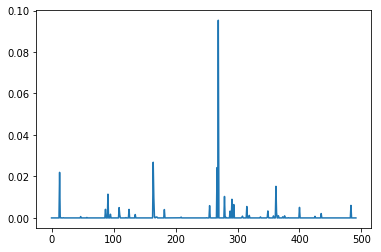

In [44]:
plt.plot(d_losses)

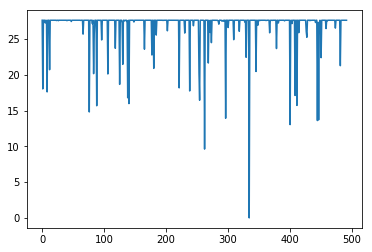

In [45]:
plt.plot(g_losses)

In [78]:
# Now we can train and test model on the generated data
synthentic_data

tensor([[ 1.3814e+00, -5.6949e-02, -5.7463e-02,  ..., -1.6260e-01,
         -5.4332e-02, -4.6051e-02],
        [-4.5472e-02, -1.0283e-01, -5.7138e-02,  ..., -5.6385e-02,
          5.2308e-02, -4.5068e-02],
        [ 1.2165e-01,  2.9972e+00, -9.1125e-03,  ...,  3.7267e+00,
         -5.5316e-02,  9.2408e-01],
        ...,
        [-1.7963e-02,  9.3903e-03,  1.9030e-02,  ...,  2.2842e-02,
         -2.0149e-02,  3.0771e-06],
        [-3.8866e-02, -1.7103e-02, -1.9109e-02,  ..., -1.4033e-02,
         -1.7922e-02, -3.6210e-01],
        [-1.6612e-02, -1.7381e-02, -1.9701e-02,  ...,  2.5594e+00,
          1.0047e+00, -3.1743e-02]])

In [79]:
# Convert array of tensor to tensors
temp = torch.Tensor(99)
synthentic_data = torch.cat(synthentic_data, out=temp)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [80]:
# Convert tensor to PD data frame
synthentic_data_df = pd.DataFrame(data=synthentic_data.data.numpy());
synthentic_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.381356,-0.056949,-0.057463,-0.040298,-0.057084,-0.056528,-0.066441,-0.057056,-0.048743,-1.982630,...,-0.057270,-0.054910,-0.051792,-0.055885,-0.056607,-0.040957,2.976045,-0.162601,-0.054332,-0.046051
1,-0.045472,-0.102833,-0.057138,0.295807,-0.097408,-0.144796,-0.055682,-0.014743,-0.300167,-0.063522,...,-0.057548,-0.045611,-0.071561,1.058161,-0.641967,3.363811,0.424565,-0.056385,0.052308,-0.045068
2,0.121647,2.997174,-0.009113,-0.061742,-0.633560,-0.057275,-0.046771,-0.053500,-0.129914,-0.932856,...,-0.361437,-0.057405,-0.059111,-1.944048,-1.632115,-0.031994,-1.712119,3.726690,-0.055316,0.924076
3,0.011625,-0.057230,-0.053383,-0.233911,0.090462,-0.058491,-0.062384,-0.085092,-0.292447,-2.205114,...,-0.058340,-0.105928,-0.542505,0.128057,-0.056475,-0.047488,-0.058267,-0.034562,-0.035444,-0.058541
4,-0.090371,-0.049098,-0.058707,0.014012,-0.062817,-0.178670,-2.141018,-0.058279,-0.079392,-1.248853,...,-0.138195,0.042109,-0.056917,-0.058688,-1.175004,-0.056022,-0.048289,-1.096804,-1.868680,-0.055720


In [81]:
# Rename columns of the synthentic dataset
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
        'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normAmount']
synthentic_data_df.columns = cols

In [82]:
# Convert tensor to PD data frame
#synthentic_data_df = pd.DataFrame(data=synthentic_data.data.numpy());
synthentic_data_df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
0,1.381356,-0.056949,-0.057463,-0.040298,-0.057084,-0.056528,-0.066441,-0.057056,-0.048743,-1.982630,...,-0.057270,-0.054910,-0.051792,-0.055885,-0.056607,-0.040957,2.976045,-0.162601,-0.054332,-0.046051
1,-0.045472,-0.102833,-0.057138,0.295807,-0.097408,-0.144796,-0.055682,-0.014743,-0.300167,-0.063522,...,-0.057548,-0.045611,-0.071561,1.058161,-0.641967,3.363811,0.424565,-0.056385,0.052308,-0.045068
2,0.121647,2.997174,-0.009113,-0.061742,-0.633560,-0.057275,-0.046771,-0.053500,-0.129914,-0.932856,...,-0.361437,-0.057405,-0.059111,-1.944048,-1.632115,-0.031994,-1.712119,3.726690,-0.055316,0.924076
3,0.011625,-0.057230,-0.053383,-0.233911,0.090462,-0.058491,-0.062384,-0.085092,-0.292447,-2.205114,...,-0.058340,-0.105928,-0.542505,0.128057,-0.056475,-0.047488,-0.058267,-0.034562,-0.035444,-0.058541
4,-0.090371,-0.049098,-0.058707,0.014012,-0.062817,-0.178670,-2.141018,-0.058279,-0.079392,-1.248853,...,-0.138195,0.042109,-0.056917,-0.058688,-1.175004,-0.056022,-0.048289,-1.096804,-1.868680,-0.055720


In [83]:
# Add 1 to Class column since they're all synthetic generated fraud data
synthentic_data_df['Class'] = 1

In [84]:
data = pd.read_csv("creditcard.csv")
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)

# Rearrange columns to the right order
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
        'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normAmount', 'Class']
data = data[cols]

In [85]:
X = np.array(data.loc[:, data.columns != 'Class'])
y = np.array(data.loc[:, data.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 29)
Shape of y: (284807, 1)


In [86]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 29)
xtest shape
(85443, 29)


In [87]:
# Split the synthentic data
X_synthentic = np.array(synthentic_data_df.loc[:, synthentic_data_df.columns != 'Class'])
y_synthentic = np.array(synthentic_data_df.loc[:, synthentic_data_df.columns == 'Class'])

In [104]:
type(X_synthentic)

numpy.ndarray

In [106]:
# Add newly generated fraud data to the training data set
new_X = np.concatenate((X_train, X_synthentic), axis=0)
new_y = np.concatenate((y_train, y_synthentic), axis=0)

In [107]:
classifier = RandomForestClassifier()
classifier.fit(new_X, new_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [109]:
# Making a Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85284,    12],
       [   36,   111]])

In [51]:
# Save the model
torch.save(generator, OUTPUT_PATH + "generator.pt")
torch.save(discriminator, OUTPUT_PATH + "discriminator.pt")

FileNotFoundError: [Errno 2] No such file or directory: '/output/generator.pt'